# Exp6. 네이버 영화리뷰 감성분석

# 1. 데이터 불러오기

In [48]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 로더 구성

1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

## 2-1. 데이터 전처리

In [49]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [50]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset = ['document'], inplace = True) # 중복값 제거 (1)
    train_data = train_data.dropna(how = 'any')  # 결측치 제거 (2)
    
    test_data.drop_duplicates(subset = ['document'], inplace = True) # 중복값 제거 (1)
    test_data = test_data.dropna(how = 'any')  # 결측치 제거 (2)
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화 (3)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 (4)
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)   # 토큰화 (3)
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거 (4)
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000 - 4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}  # 사전 word_to_index 구성 (5)
    
    def wordlist_to_indexlist(wordlist):        # 텍스트 스트링을 사전 인덱스 스트링으로 변환 (6)
        return[word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
# X_train, y_train, X_test, y_test, word_to_index 리턴 (7)

In [51]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [52]:
print('train 데이터 개수 : ', len(X_train))
print('test 데이터 개수 :', len(X_test))

train 데이터 개수 :  146182
test 데이터 개수 : 49157


In [53]:
# {텍스트 : 인덱스} → {인덱스 : 텍스트}

index_to_word = {index:word for word, index in word_to_index.items()}

## 2-2. encoding, decoding

In [54]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word]         # 모든 문장은 <BOS>로 시작 → 항상 첫번째는 1이 출력
                                       if word in word_to_index    # 단어 가져오기
                                       else word_to_index['<UNK>'] # 단어가 없으면 <UNK>인덱스 가져오기
                                       for word in sentence.split()]  # sentence에 있는 문장 나눠서 단어로 출력

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수
def get_encoded_sentences(sentence, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '. join(index_to_word[index]
                     if index in index_to_word
                     else '<UNK>'
                     for index in encoded_sentence[1:])  # [1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [55]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('1번째 문장 라벨 :', y_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
1번째 문장 라벨 : 0


# 3. 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

## 3-1. 데이터셋 내 문장 길이 분포 확인
* maxlen의 적절한 값을 찾기 위해 전체 데이터셋의 분포를 확인하는 것이 좋음!

In [56]:
import numpy as np

total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

문장길이 평균 : 15.96940191154864
문장길이 최대 : 116
문장길이 표준편차 : 12.843571191092


## 3-2. 최대 문장 길이 지정
* maxlen 값 설정이 전체 모델 성능에 영향을 미침

In [57]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences_maxlen :', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences_maxlen : 41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다.


## 3-3. 문장 길이 맞추기 (패딩 추가)
* keras.preprocessing.sequence.pad_sequences 을 활용한 문장 길이 맞추기
* padding = 'pre' : 문장의 길이가 maxlen보다 짧은 경우, 문장 앞에 <PAD>를 추가

In [58]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value = word_to_index['<PAD>'],
                                                       padding = 'pre',   # 문장 앞에 패딩 추가
                                                       maxlen = maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                      value = word_to_index['<PAD>'],
                                                      padding = 'pre',
                                                      maxlen = maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [59]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리


# 4. validation set 구성

In [60]:
X_val = X_train[:46000]
y_val = y_train[:46000]

partial_X_train = X_train[46000:]
partial_y_train = y_train[46000:]

print(X_val.shape)
print(y_val.shape)

print(partial_X_train.shape)
print(partial_y_train.shape)

(46000, 41)
(46000,)
(100182, 41)
(100182,)


# 5. 모델 구성, 훈련, 시각화

## 5-1. RNN
* 입력과 출력을 시퀀스 단위로 처리하는 시퀀스(Sequence) 모델 (가장 기본적인 인공 신경망 시퀀스 모델)
* 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서 은닉층 노드의 다음 계산의 입력으로 보내는 특징이 있음
* [RNN 추가 공부](https://wikidocs.net/22886)

### 5-1-1. 모델 구성

In [61]:
vocab_size = 10000   # 단어사진 크기
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경 가능한 하이퍼파라마터)

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model_1.add(tf.keras.layers.LSTM(8))  # LSTM 레이어 사용 & LSTM 벡터의 차원 수 변경 가능
model_1.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_1.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


### 5-1-2. 모델 훈련

In [62]:
model_1.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

epochs = 5

history_1 = model_1.fit(partial_X_train,
                        partial_y_train,
                        epochs = epochs,
                        batch_size = 512,
                        validation_data = (X_val, y_val),
                        verbose = 1)

Epoch 1/5
196/196 [==============================] - 3s 8ms/step - loss: 0.5250 - accuracy: 0.7743 - val_loss: 0.3836 - val_accuracy: 0.8380
Epoch 2/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3500 - accuracy: 0.8526 - val_loss: 0.3500 - val_accuracy: 0.8490
Epoch 3/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8691 - val_loss: 0.3471 - val_accuracy: 0.8502
Epoch 4/5
196/196 [==============================] - 1s 6ms/step - loss: 0.3015 - accuracy: 0.8775 - val_loss: 0.3482 - val_accuracy: 0.8511
Epoch 5/5
196/196 [==============================] - 1s 6ms/step - loss: 0.2898 - accuracy: 0.8832 - val_loss: 0.3488 - val_accuracy: 0.8504


In [63]:
results_1 = model_1.evaluate(X_test, y_test, verbose = 2)
print(results_1)

1537/1537 - 3s - loss: 0.3613 - accuracy: 0.8445
[0.3613210916519165, 0.8445186018943787]


In [64]:
history_1_dict = history_1.history

print(history_1_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 5-1-3. Loss, Accuracy 그래프 시각화

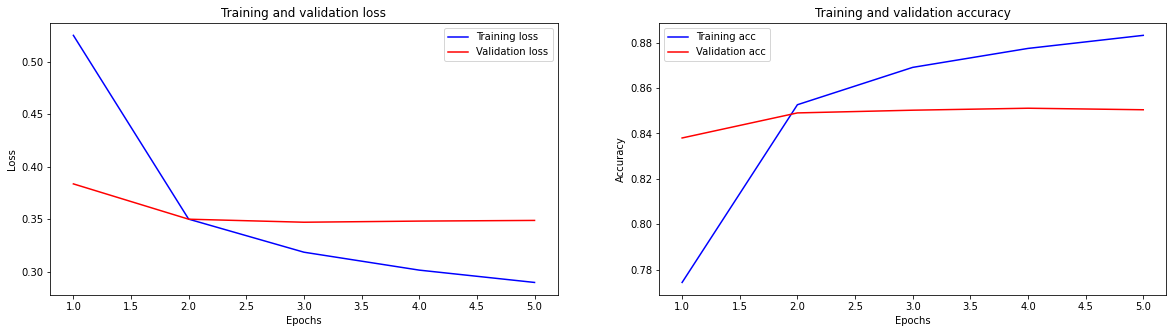

In [65]:
import matplotlib.pyplot as plt

acc = history_1_dict['accuracy']
val_acc = history_1_dict['val_accuracy']

loss = history_1_dict['loss']
val_loss = history_1_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5-2. 1-D Convolution Neural Network(1-D CNN)
* 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝하면서 7단어 이내에서 발견되는 특징을 추출하여 문장을 분류하는 방식
* [1-D CNN 추가공부](https://wikidocs.net/80437)

### 5-2-1. 모델 구성

In [66]:
vocab_size = 10000 
word_vector_dim = 16 

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

### 5-2-2. 모델 훈련

In [67]:
model_2.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

epochs = 5

history_2 = model_2.fit(partial_X_train,
                        partial_y_train,
                        epochs = epochs,
                        batch_size = 512,
                        validation_data = (X_val, y_val),
                        verbose = 1)

Epoch 1/5
196/196 [==============================] - 2s 6ms/step - loss: 0.5113 - accuracy: 0.7458 - val_loss: 0.3598 - val_accuracy: 0.8425
Epoch 2/5
196/196 [==============================] - 1s 5ms/step - loss: 0.3314 - accuracy: 0.8581 - val_loss: 0.3426 - val_accuracy: 0.8515
Epoch 3/5
196/196 [==============================] - 1s 5ms/step - loss: 0.2962 - accuracy: 0.8760 - val_loss: 0.3427 - val_accuracy: 0.8510
Epoch 4/5
196/196 [==============================] - 1s 5ms/step - loss: 0.2686 - accuracy: 0.8903 - val_loss: 0.3468 - val_accuracy: 0.8522
Epoch 5/5
196/196 [==============================] - 1s 5ms/step - loss: 0.2381 - accuracy: 0.9065 - val_loss: 0.3598 - val_accuracy: 0.8496


In [68]:
results_2 = model_2.evaluate(X_test, y_test, verbose = 2)
print(results_2)

1537/1537 - 2s - loss: 0.3719 - accuracy: 0.8463
[0.3719228506088257, 0.8463290929794312]


In [69]:
history_2_dict = history_2.history

print(history_2_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 5-2-3. Loss, Accuracy 그래프 시각화

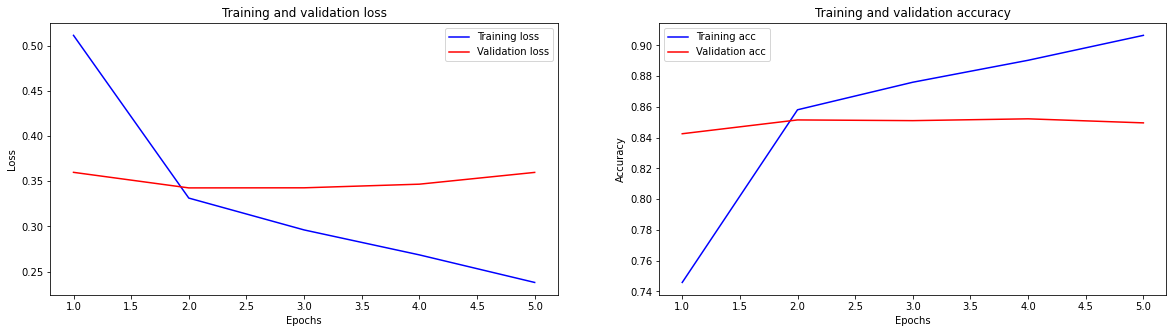

In [70]:
acc = history_2_dict['accuracy']
val_acc = history_2_dict['val_accuracy']

loss = history_2_dict['loss']
val_loss = history_2_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 5-3. GlobalMaxPooling1D
* GlobalMaxPooling1D() 레이어 하나만 사용하는 방법
* 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환
* 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 긍정/부정을 평가
* [GlobalMaxPooling1D 추가 공부](https://tykimos.github.io/2017/08/17/Text_Input_Binary_Classification_Model_Recipe/)

### 5-3-1. 모델 구성

In [71]:
vocab_size = 10000 
word_vector_dim = 16 

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5-3-2. 모델 훈련

In [72]:
model_3.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

epochs = 5

history_3 = model_3.fit(partial_X_train,
                        partial_y_train,
                        epochs = epochs,
                        batch_size = 512,
                        validation_data = (X_val, y_val),
                        verbose = 1)

Epoch 1/5
196/196 [==============================] - 1s 4ms/step - loss: 0.6208 - accuracy: 0.7586 - val_loss: 0.4879 - val_accuracy: 0.8105
Epoch 2/5
196/196 [==============================] - 1s 4ms/step - loss: 0.4123 - accuracy: 0.8290 - val_loss: 0.3781 - val_accuracy: 0.8345
Epoch 3/5
196/196 [==============================] - 1s 4ms/step - loss: 0.3438 - accuracy: 0.8550 - val_loss: 0.3583 - val_accuracy: 0.8424
Epoch 4/5
196/196 [==============================] - 1s 4ms/step - loss: 0.3110 - accuracy: 0.8709 - val_loss: 0.3537 - val_accuracy: 0.8451
Epoch 5/5
196/196 [==============================] - 1s 4ms/step - loss: 0.2874 - accuracy: 0.8823 - val_loss: 0.3559 - val_accuracy: 0.8459


In [73]:
results_3 = model_3.evaluate(X_test, y_test, verbose = 2)
print(results_3)

1537/1537 - 2s - loss: 0.3664 - accuracy: 0.8406
[0.36635255813598633, 0.8406127095222473]


In [74]:
history_3_dict = history_3.history

print(history_3_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 5-3-3. Loss, Accuracy 그래프 시각화

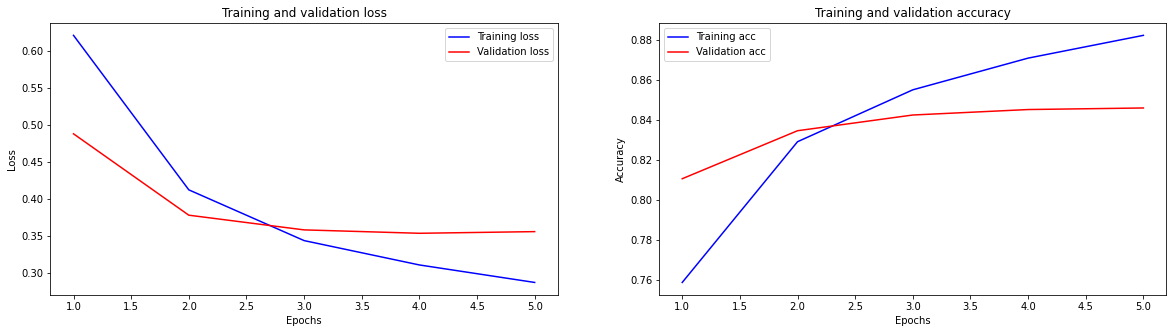

In [75]:
acc = history_3_dict['accuracy']
val_acc = history_3_dict['val_accuracy']

loss = history_3_dict['loss']
val_loss = history_3_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [76]:
#RNN
results_1 = model_1.evaluate(X_test, y_test, verbose = 2)

# 1-D CNN
results_2 = model_2.evaluate(X_test, y_test, verbose = 2)

# GlobalMaxPooling1D
results_3 = model_3.evaluate(X_test, y_test, verbose = 2)

1537/1537 - 3s - loss: 0.3613 - accuracy: 0.8445
1537/1537 - 2s - loss: 0.3719 - accuracy: 0.8463
1537/1537 - 2s - loss: 0.3664 - accuracy: 0.8406


# 6. 학습된 Embedding 레이어 분석
* Embedding 레이어에 있는 워드 벡터가 잘 학습이 되었는지 확인
* 위에서 훈련한 3가지 모델 중에 [RNN 모델]로 Embedding 레이어 분석을 하였다.

In [77]:
embedding_layer = model_1.layers[0]
weights = embedding_layer.get_weights()[0]

print(weights.shape)       # shape : (vocab_size, embedding_dim)

(10000, 16)


In [78]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀 쓰기

# 단어 개수만큼의 워드 벡터를 파일에 기록
# 단, 단어 개수에서 특수문자 4개는 제외해야 함
vectors = model_1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [79]:
# gensim 패키지를 이용해 Embedding 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary = False)
vector = word_vectors['추천']
vector

array([-0.05309832,  0.07722419,  0.1329387 ,  0.1458422 , -0.12471265,
       -0.05207187, -0.00109677, -0.05416569, -0.06741141, -0.10612854,
        0.25304615, -0.02541902,  0.09251431,  0.06082781,  0.04385027,
       -0.04519425], dtype=float32)

In [80]:
# 워드 벡터가 의미 벡터 공간 상에 유의미하게 학습되었는지 확인하는 방법 1
# 단어를 하나 주고 가장 유사한 단어와 유사도를 확인하는 방법

word_vectors.similar_by_word("만족")

[('훌쩍', 0.9646713733673096),
 ('반대편', 0.9610562324523926),
 ('담겨져', 0.9604763984680176),
 ('이끈', 0.9603986740112305),
 ('최상', 0.9603320360183716),
 ('들으면', 0.9601010680198669),
 ('평온', 0.959425687789917),
 ('일품', 0.9584933519363403),
 ('뭉클', 0.9560309648513794),
 ('이준기', 0.9557766914367676)]

# 7. 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 7-1. 한국어 Word2Vec 임베딩 적용

In [81]:
import gensim
from gensim.models import KeyedVectors

In [82]:
gensim.__version__

'3.8.3'

In [83]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [84]:
vector = word2vec['추천']
vector

array([-0.21245585, -0.76455975,  1.2335763 , -2.0687602 ,  0.11830104,
       -0.54881305, -1.1947731 ,  0.3467694 , -1.0311009 , -0.3603907 ,
        1.3440485 , -0.4072002 ,  1.1131706 , -0.9551345 , -0.7064215 ,
       -0.1686603 , -0.58696073, -1.4859254 ,  0.05223045, -0.23236327,
        0.6323806 , -1.1020958 , -1.2635112 ,  0.6220531 ,  0.17838949,
       -0.70615005, -1.3628044 , -1.4818763 , -0.18965532,  0.11690602,
       -0.09560227, -0.39899632,  1.0731212 , -0.63874424,  0.017969  ,
        0.98583263,  1.3941766 ,  0.08089745, -0.81685823, -0.7022943 ,
       -0.5008832 , -0.54513174,  0.34584457, -1.7315279 , -0.24291196,
        0.6328651 ,  1.4537793 , -0.7011548 ,  0.80850524,  0.74069935,
       -0.9272299 , -1.335555  , -1.1335523 ,  3.2529519 ,  0.6823866 ,
       -1.4942434 ,  3.213415  ,  1.0216335 , -0.4152105 , -0.11520938,
       -0.08406533, -0.49404764, -1.7769778 ,  0.19683318,  0.48151487,
       -0.67674905, -1.5347718 ,  0.17763563, -0.6901806 , -0.71

In [85]:
word2vec.similar_by_word("추천")

[('위촉', 0.6401861906051636),
 ('천거', 0.6389721632003784),
 ('추대', 0.5849215984344482),
 ('선출', 0.5803494453430176),
 ('초청', 0.5759262442588806),
 ('발탁', 0.5613522529602051),
 ('선정', 0.5511638522148132),
 ('임명', 0.5414161682128906),
 ('초빙', 0.5363222360610962),
 ('기용', 0.5326868295669556)]

In [86]:
word2vec.similar_by_word("만족")

[('충족', 0.7622718811035156),
 ('납득', 0.5126502513885498),
 ('기약', 0.4881259799003601),
 ('동치', 0.4837648272514343),
 ('부합', 0.47508636116981506),
 ('극대화', 0.4693123698234558),
 ('성취', 0.465419203042984),
 ('상쇄', 0.4648754596710205),
 ('상기', 0.45204538106918335),
 ('일반화', 0.45000725984573364)]

In [87]:
word2vec.similar_by_word("별로")

[('그다지', 0.516608476638794),
 ('지역별', 0.49092748761177063),
 ('전혀', 0.48824024200439453),
 ('각기', 0.4875951111316681),
 ('개별', 0.47797343134880066),
 ('따로', 0.4700734317302704),
 ('마다', 0.46785035729408264),
 ('별', 0.45661038160324097),
 ('딱히', 0.4535921812057495),
 ('다소', 0.43761277198791504)]

## 7-2. RNN
* 위에서 진행한 모델 중 가장 accuracy가 높은 RNN 모델로 진행하였다.
* LSTM 레이어 수를 8로 진행하였을 때는 accuracy가 84%로 나왔다.  
    → LSTM 레이어 수를 64로 변경하였다.
* epochs 수를 처음에는 20으로 하였는데 accuracy가 점점 떨어져 epochs 수를 5로 줄였다.

### 7-2-1. 모델 구성

In [88]:
from tensorflow.keras.initializers import Constant

In [89]:
vocab_size = 10000 
word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피함
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [90]:
model_4 = tf.keras.Sequential()
model_4.add(tf.keras.layers.Embedding(vocab_size,
                                   word_vector_dim,
                                   embeddings_initializer = Constant(embedding_matrix),
                                   input_length = maxlen,
                                   trainable = True))
model_4.add(tf.keras.layers.LSTM(64))  # LSTM 레이어 사용 & LSTM 벡터의 차원 수 변경 가능
model_4.add(tf.keras.layers.Dense(8, activation = 'relu'))
model_4.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # 최종 출력은 긍정/부정을 나타내는 1dim

model_4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________


### 7-2-2. 모델 훈련

In [91]:
model_4.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

epochs = 5

history_4 = model_4.fit(partial_X_train,
                        partial_y_train,
                        epochs = epochs,
                        batch_size = 512,
                        validation_data = (X_val, y_val),
                        verbose = 1)

Epoch 1/5
196/196 [==============================] - 3s 11ms/step - loss: 0.4817 - accuracy: 0.7629 - val_loss: 0.3800 - val_accuracy: 0.8307
Epoch 2/5
196/196 [==============================] - 2s 9ms/step - loss: 0.3478 - accuracy: 0.8482 - val_loss: 0.3426 - val_accuracy: 0.8510
Epoch 3/5
196/196 [==============================] - 2s 9ms/step - loss: 0.3031 - accuracy: 0.8712 - val_loss: 0.3318 - val_accuracy: 0.8568
Epoch 4/5
196/196 [==============================] - 2s 9ms/step - loss: 0.2736 - accuracy: 0.8869 - val_loss: 0.3317 - val_accuracy: 0.8598
Epoch 5/5
196/196 [==============================] - 2s 9ms/step - loss: 0.2517 - accuracy: 0.8965 - val_loss: 0.3310 - val_accuracy: 0.8610


In [92]:
results_4 = model_4.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3442 - accuracy: 0.8534


In [93]:
history_4_dict = history_4.history

print(history_4_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 7-2-3. Loss, Accuracy 그래프 시각화

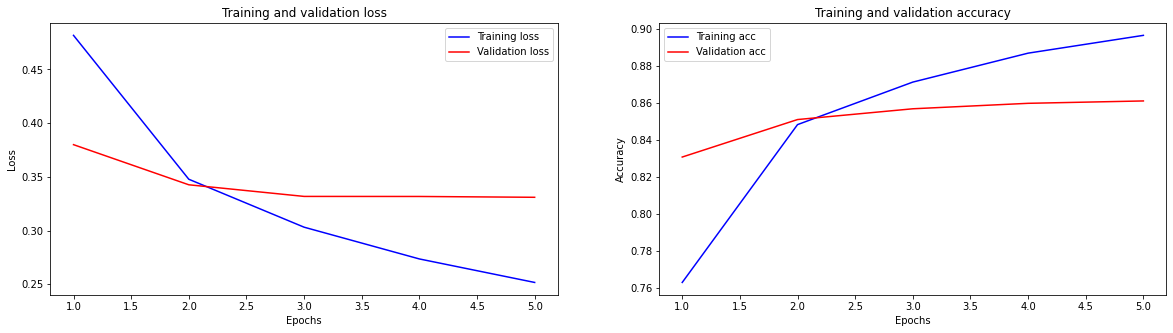

In [94]:
acc = history_4_dict['accuracy']
val_acc = history_4_dict['val_accuracy']

loss = history_4_dict['loss']
val_loss = history_4_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

## 1) 모델

* RNN, 1-D CNN, GlobalMaxPooling1D 총 3가지의 모델을 구성하고 훈련하였다. 
* accuracy가 비슷하긴 했지만 그중에서 가장 높은 모델은 RNN이었다. 그래서 RNN모델로 embedding 레이어를 분석해보았다.
* LMS에 나와있는 3가지 모델을 활용하였는데, 정확하게 해당 모델들의 특징들을 파악하고 사용한 것이 아니라 그냥 따라했어서 모델들에 대해 더 공부를 해야 할 필요성을 느꼈다.

## 2) Embedding 레이어 분석
* 학습한 Embedding 레이어로 주어진 단어와 유사한 단어를 출력해내는데 유사하지 않은 단어들도 많이 출력되었다.
* 한국어 Word2Vec 임베딩을 사용하였을 때는 확실히 유사한 단어를 많이 출력해냈으며 다양한 단어들도 많이 출력된 것을 볼 수 있다.

## 3) accuracy
* 학습한 3가지의 모델의 accuracy는 다 비슷하지만 85%가 넘지 않았다.
* 모델 학습 시에 에포크 수를 10으로 했는데, accuracy가 중간에 다시 떨어지는 것을 보고 모델의 에포크 수를 10 → 5로 줄였다.
* 에포크 5로 줄이니 accuracy가 84%까지 올라간 것을 확인할 수 있었다.
* 한국어 Word2Vec 임베딩을 진행한 후 RNN 모델을 학습한 결과, 85%를 넘게 되었다.
* 처음에는 85%가 넘지 않아 LSTM 레이어수를 8 → 64로 늘렸고, 에포크 수를 많이 하니 정확도가 다시 떨어지기 시작하여 에포크 수를 5로 줄였다.

## 4) 후기
* 각 모델의 accuracy와 loss들을 시각화하니 명확하게 알 수 있어서 시각화의 중요성을 알게 되었다. 시각화 한 코드들을 볼 때마다 어렵다고만 생각했는데 이렇게 기본적인 것부터 하나씩 해가면 다른 것들도 시각화를 할 수 있지 않을까 생각했다.
* 문장 최대 길이, 패딩 등 데이터를 가공하는 방법이 다양하게 있어서 이런 것들을 추가로 알고 싶었다.
* 원래 NLP에는 큰 관심이 없었는데 이번 프로젝트를 진행하면서 NLP에 대해 관심이 생겨 좀 더 공부하고 싶어졌다.
* 분류가 얼마나 잘 되었는지 accuracy로 확인을 하였는데, 실제로 각 리뷰 별로 어떻게 분류되었는지 확인해보고 싶었다. (⭐추가 공부 필요,,)
* LMS이외에 DACON에서 진행한 대회의 각 코드들을 리뷰하며 다양한 방법을 시도해보고 싶다.
* [DACON 영화 리뷰 감성분석 경진대회](https://dacon.io/competitions/official/235864/overview/description)
* [코드리뷰하고 싶은 코드1](https://dacon.io/competitions/official/235864/codeshare/4126?page=1&dtype=recent)
* [코드리뷰하고 싶은 코드2](https://dacon.io/competitions/official/235864/codeshare/4160?page=1&dtype=vote)

## 5) Reference
* 명예의 전당에 오른 이전 기수분들의 코드 참고하였음
* https://github.com/hyyoo3526/AIFFEL_EXPLORATION/blob/main/EXPLORATION_07/EXPLORATION_IC1_07_sentiment_classification.ipynb
* https://github.com/ai-rtistic/AIFFEL-Project/blob/master/Exploration/EP07_Naver_Movie_Sentiment_Classification.ipynb